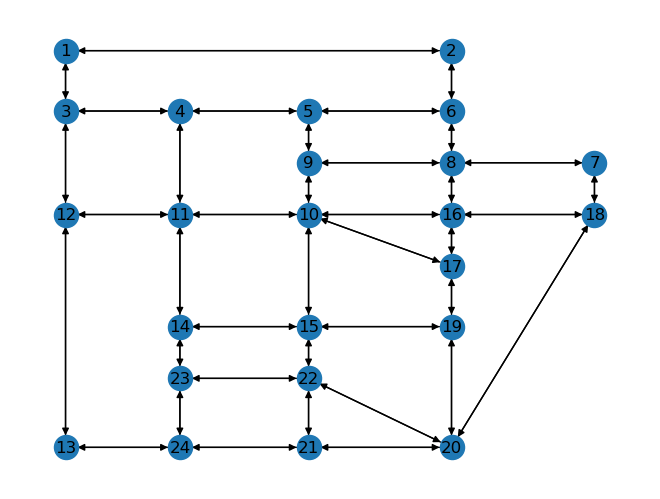

In [6]:
import pandas as pd

data_xy = pd.read_csv("data/network/SiouxFallsNetwork.csv")
data_xy_pos = pd.read_csv("data/network/SiouxFallsXY.csv", index_col=0)
data_xy_pos = data_xy_pos.set_index('node').apply(lambda row: (row.x, row.y), axis=1).to_dict()
speed = 80  # km/h
data_xy_traveltime = {(int(row["from"]), int(row["to"])): row["length"]/(speed*1000/60) for _, row in data_xy.iterrows()} # minutes

import networkx as nx

graph = nx.from_pandas_edgelist(data_xy, source="from", target="to", edge_attr=True, create_using=nx.DiGraph())
nx.set_node_attributes(graph, data_xy_pos, 'pos')
nx.set_edge_attributes(graph, data_xy_traveltime, 'travel_time')

class Lane:
    def __init__(self, 
                 id_: str, 
                 num_blocks: int, 
                 each_block_length: float,
                 each_block_capacity: int):
        self.id_ = id_
        self.length = num_blocks * each_block_length
        self.each_block_capacity = each_block_capacity
        self.capacity = num_blocks * each_block_capacity
        self.num_blocks = num_blocks
        self.stats = {i: 0 for i in range(num_blocks)}
        
    def __str__(self):
        return f"Lane {self.id_}: length={self.length}m, capacity={self.capacity}veh, blocks={self.num_blocks}"

    def __repr__(self):
        return self.__str__()

    def add_vehicle(self, block: int):
        self.stats[block] += 1
    
    def remove_vehicle(self, block: int):
        self.stats[block] -= 1
        
    def is_full(self, block: int) -> bool:
        return self.stats[block] >= self.each_block_capacity
        
for edge in graph.edges(data=True):
    lane_id = 0
    num_blocks = edge[2]["length"] // 100
    lane = Lane(id_=lane_id, num_blocks=num_blocks, each_block_length=100, each_block_capacity=10)
    graph.edges[(edge[0], edge[1])]["lane"] = lane
            
            
class Intersection:
    def __init__(self, directions: list):
        self.num_directions = len(directions)
        self.directions = directions
        self.light_stats = {direction: "red" for direction in directions}
        self.stats = -1
        self.update_lights_according_to_logic()
        
    def __str__(self):
        return f"Intersection: {self.light_stats}"
    
    def __repr__(self):
        return self.__str__()
        
    def change_light(self, direction: str, color: str):
        self.light_stats[direction] = color

    def update_lights_according_to_logic(self):
        self.stats = (self.stats + 1) % self.num_directions
        for i, direction in enumerate(self.directions):
            if i == self.stats:
                self.change_light(direction, "green")
            else:
                self.change_light(direction, "red")

for node in graph.nodes:
    neighbors = list(graph.successors(node))
    intersection = Intersection(directions=neighbors)
    graph.nodes[node]["intersection"] = intersection
    
nx.draw(graph, with_labels=True, pos=data_xy_pos)

## Stats Class Implementation

## Vehicle Class Implementation